# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from typing import Callable, Optional, Tuple, List, Dict
import matplotlib.pyplot as plt

np.bool8 = np.bool_

# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Your code here. Call .reset() on the environment and inspect the output. Also, check out the observation_space.

env.reset()
#env_render.reset()

(array([ 0.0358028 ,  0.00836428, -0.01174046, -0.02960652], dtype=float32),
 {})

**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 

In [ ]:
def compute_returns(rewards: List[float], gamma: float) -> List[float]:
    """Compute discounted returns for each step in an episode."""
    returns = []
    running_return = 0
    for r in reversed(rewards):
        running_return = r + gamma * running_return
        returns.insert(0, running_return)
    return returns

def run_episode(env: gym.Env, 
               policy: torch.nn.Module,
               max_steps: int = 1000) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, List[float]]:
    """Run a single episode using the current policy."""
    observations = []
    actions = []
    log_probs = []
    rewards = []
    
    # Handle new Gym API (v0.26+) which returns tuple from reset()
    obs, _ = env.reset()
    done = False
    steps = 0
    
    while not done and steps < max_steps:
        # Convert numpy array to tensor
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        
        # Get action distribution from policy
        action_dist = policy(obs_tensor)
        
        # Sample action
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        
        # Take action in environment (new Gym API returns 5 values)
        next_obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        
        # Store transition
        observations.append(obs_tensor)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        
        obs = next_obs
        steps += 1
    
    # Convert lists to tensors
    observations = torch.cat(observations).to(device)
    actions = torch.cat(actions).to(device)
    log_probs = torch.cat(log_probs).to(device)
    
    return observations, actions, log_probs, rewards

In [ ]:
class REINFORCE:
    """REINFORCE policy gradient algorithm with proper evaluation metrics."""
    
    def __init__(self,                  
                 policy: torch.nn.Module,
                 gamma: float = 0.99,
                 learning_rate: float = 1e-2
                 ):
        self.policy = policy
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=learning_rate)  
        self.gamma = gamma
        self.training_metrics = {
            'eval_rewards': [],
            'eval_lengths': [],
            'timesteps': []
        }
    
    def evaluate_policy(self, 
                       env: gym.Env, 
                       num_episodes: int = 10) -> Tuple[float, float]:
        """
        Evaluate policy by running multiple episodes.
        
        Args:
            env: Environment to evaluate in
            num_episodes: Number of evaluation episodes
            
        Returns:
            Tuple of (average total reward, average episode length)
        """
        total_rewards = []
        episode_lengths = []
        
        self.policy.eval()
        with torch.no_grad():
            for _ in range(num_episodes):
                obs, _ = env.reset()
                done = False
                total_reward = 0
                steps = 0
                
                while not done:
                    obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                    action = self.policy(obs_tensor).sample().item()
                    obs, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated
                    total_reward += reward
                    steps += 1
                
                total_rewards.append(total_reward)
                episode_lengths.append(steps)
        #print(total_rewards)
        avg_reward = np.mean(total_rewards)
        avg_length = np.mean(episode_lengths)
        return avg_reward, avg_length
    
    def train(self, 
             env: gym.Env,
             num_episodes: int = 1000,
             eval_every: int = 100,
             eval_episodes: int = 10,
             render_every: Optional[int] = None,
             early: bool = True) -> Dict[str, List]:
        """
        Train the policy with periodic evaluation.
        
        Args:
            env: Training environment
            num_episodes: Total training episodes
            eval_every: Evaluate every N episodes
            eval_episodes: Number of episodes for evaluation (M)
            render_every: Optional render frequency
            
        Returns:
            Dictionary containing training metrics:
            - eval_rewards: List of evaluation average rewards
            - eval_lengths: List of evaluation average lengths
            - timesteps: List of evaluation timesteps
        """
        self.policy.train()
        timestep = 0
        best_reward = 0
        avg_length = 0
        avg_reward = 0
        count_early = 0
        
        for episode in range(1, num_episodes + 1):
            # Run training episode
            observations, actions, log_probs, rewards = run_episode(env, self.policy)
            timestep += len(rewards)
            
            # Update policy
            returns = torch.tensor(compute_returns(rewards, self.gamma), dtype=torch.float32).to(device)
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
            loss = (-log_probs * returns).mean()

            # Add this to your training loop after the update:
            if episode > 200 and episode % 50 == 0 and avg_reward >= 200:
                for g in self.optimizer.param_groups:
                    g['lr'] *= 0.9  # Gentle decay after episode 200
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Periodic evaluation every N episodes
            if episode % eval_every == 0:
                avg_reward, avg_length = self.evaluate_policy(env, eval_episodes) # M = eval_episodes
                self.training_metrics['eval_rewards'].append(avg_reward)
                self.training_metrics['eval_lengths'].append(avg_length)
                self.training_metrics['timesteps'].append(timestep)
                
                print(f"Episode {episode} | "
                      f"Avg Reward: {avg_reward:.1f} | "
                      f"Avg Length: {avg_length:.1f} | "
                      f"Timesteps: {timestep}")

                # Early stopping
                if avg_reward >= 485 and early == True:
                    count_early += 1
                    print(f"The top was reached {count_early} times in a row")
                    if count_early >= 5:  # Require 5 consecutive good evaluations
                        print(f"Consistent solution achieved at episode {episode}")
                        break
                else:
                    count_early = 0  # Reset counter if performance drops
            
            # Optional rendering
            if render_every and episode % render_every == 0:
                self.policy.eval()
                run_episode(gym.make('CartPole-v1', render_mode='human'), self.policy)
                self.policy.train()
        
        return self.training_metrics

In [6]:
class PolicyNet(nn.Module):
    """Policy network for CartPole that returns action distributions."""
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, env.action_space.n)
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s)  # Output logits, don't apply softmax here
        return torch.distributions.Categorical(logits=s)  # Let PyTorch handle softmax in Categorical

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

Episode 50 | Avg Reward: 21.9 | Avg Length: 21.9 | Timesteps: 986
Episode 100 | Avg Reward: 59.1 | Avg Length: 59.1 | Timesteps: 3011
Episode 150 | Avg Reward: 205.2 | Avg Length: 205.2 | Timesteps: 9248
Episode 200 | Avg Reward: 456.8 | Avg Length: 456.8 | Timesteps: 25010
Episode 250 | Avg Reward: 125.4 | Avg Length: 125.4 | Timesteps: 39089
Episode 300 | Avg Reward: 337.9 | Avg Length: 337.9 | Timesteps: 48911
Episode 350 | Avg Reward: 472.1 | Avg Length: 472.1 | Timesteps: 68049
Episode 400 | Avg Reward: 483.6 | Avg Length: 483.6 | Timesteps: 91580
Episode 450 | Avg Reward: 483.9 | Avg Length: 483.9 | Timesteps: 116280
Episode 500 | Avg Reward: 498.8 | Avg Length: 498.8 | Timesteps: 141188
The top was reached 1 times in a row
Episode 550 | Avg Reward: 497.6 | Avg Length: 497.6 | Timesteps: 165893
The top was reached 2 times in a row
Episode 600 | Avg Reward: 466.4 | Avg Length: 466.4 | Timesteps: 187777
Episode 650 | Avg Reward: 497.0 | Avg Length: 497.0 | Timesteps: 212455
The top

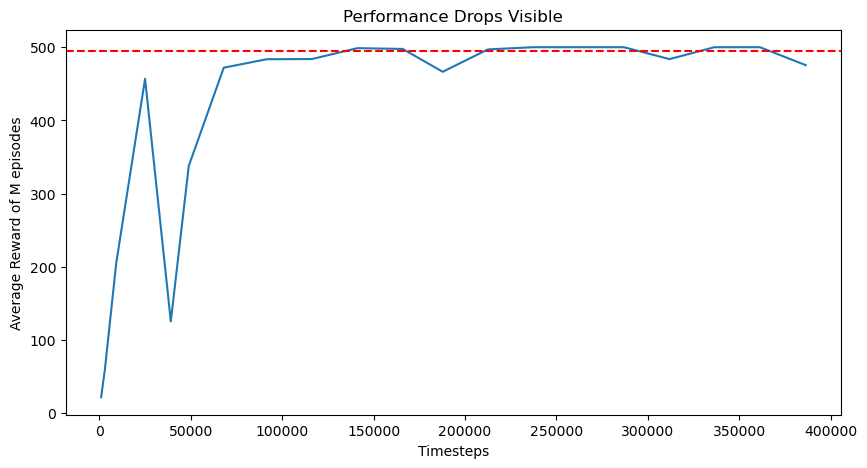

In [ ]:
device = torch.device("cpu")
# con gpu 13m 20s
# con cpu 5m 41s

# Usage example:
if __name__ == "__main__":

    M = 20 # Number of evaluation episodes run during each evaluation phase (M)
    N = 50 # Policy evalution every 50 episodes (N)

    seed = 2112
    torch.manual_seed(seed)
    np.random.seed(seed)

    env = gym.make('CartPole-v1')
    env.reset(seed=seed)
    
    policy = PolicyNet(env).to(device)  # Using the PolicyNet from previous implementation
    
    agent = REINFORCE(policy, 
                    gamma=0.99,
                    learning_rate=5e-3,
                    )  # Reduced from 1e-2
    
    # Train with evaluation every 50 episodes using 10 evaluation episodes
    metrics = agent.train(
        env, 
        num_episodes=1000, 
        eval_every=N, 
        eval_episodes=M,
        #render_every=100,  # Optional rendering
        early = True
    )

    policy.eval()
    test_rewards = []
    for _ in range(100):
        _, _, _, rewards = run_episode(env, policy)
        test_rewards.append(sum(rewards))
    print(f"True average performance: {np.mean(test_rewards):.1f} ± {np.std(test_rewards):.1f}")
    
    # Plotting the results (would need matplotlib)
    plt.figure(figsize=(10,5))
    plt.plot(metrics['timesteps'], metrics['eval_rewards'])
    plt.axhline(495, c='r', linestyle='--', label='Target')
    plt.xlabel('Timesteps')
    plt.ylabel(f'Average Reward of M episodes')
    plt.title('Performance Drops Visible')
    plt.show()

**How CartPole Scoring Works:**
- +1 reward for every step pole stays upright
- Maximum episode length: 500 steps (hence max reward = 500)
- Termination when:
    + Pole angle > 12°
    + Cart moves > 2.4 units from center
    + 500 steps reached

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from typing import Callable, Optional, Tuple, List, Dict
import matplotlib.pyplot as plt

np.bool8 = np.bool_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class REINFORCEWithBaseline:
    def __init__(self, policy_net, gamma=0.99, lr_policy=1e-3,
                 use_value_baseline=False, value_net=None, lr_value=1e-3):
        self.policy = policy_net
        self.gamma = gamma
        self.use_value_baseline = use_value_baseline
        self.value_net = value_net
        self.optimizer_policy = torch.optim.Adam(policy_net.parameters(), lr=lr_policy)

        if use_value_baseline:
            self.optimizer_value = torch.optim.Adam(value_net.parameters(), lr=lr_value)

    def update(self, states, actions, rewards):
        # Compute discounted returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)

        states = torch.cat(states).to(device)

        if self.use_value_baseline:
            # Train value net and use state-dependent baseline
            values = self.value_net(states).squeeze()
            advantages = returns - values.detach()

            # Value function update
            value_loss = F.mse_loss(values, returns)
            self.optimizer_value.zero_grad()
            value_loss.backward()
            self.optimizer_value.step()
        else:
            # Use standardization baseline
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
            advantages = returns  # since no value baseline

        # Policy gradient update
        log_probs = torch.cat([self.policy(s).log_prob(a) for s, a in zip(states, actions)]).to(device)

        # Fixed entropy calculation for discrete actions
        probs = torch.exp(log_probs)
        entropy = -torch.mean(probs * log_probs)  # Removed dim=1 for scalar probabilities
        
        policy_loss = -(log_probs * advantages).mean() - 0.01 * entropy  # 0.01 is a hyperparameter
        # policy_loss = -(log_probs * advantages).mean()

        self.optimizer_policy.zero_grad()
        policy_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=1.0)  # Clip policy gradients

        self.optimizer_policy.step()


In [3]:
def run_episode(env, policy, value_net=None, max_steps=1000):
    states, actions, rewards = [], [], []
    obs, _ = env.reset()
    done = False
    steps = 0

    while not done and steps < max_steps:
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        action_dist = policy(obs_tensor)
        action = action_dist.sample()
        
        next_obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        states.append(obs_tensor)
        actions.append(action)
        rewards.append(reward)
        
        obs = next_obs
        steps += 1

    return states, actions, rewards

def evaluate_policy_baseline(env, policy, num_episodes=10):
    """Standalone evaluation function."""
    total_rewards = []
    policy.eval()  # Set to evaluation mode
    with torch.no_grad():
        for _ in range(num_episodes):
            obs, _ = env.reset()
            done = False
            total_reward = 0
            while not done:
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                action = policy(obs_tensor).sample().item()
                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
            total_rewards.append(total_reward)
    return np.mean(total_rewards)
    

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 

In [5]:
# Your code here. Modify your implementation of REINFORCE to optionally use the standardize baseline.
class ValueNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)  # Outputs a scalar (value estimate)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

Episode 0, Avg Reward: 32.9
Episode 50, Avg Reward: 80.0
Episode 100, Avg Reward: 116.1
Episode 150, Avg Reward: 337.8
Episode 200, Avg Reward: 380.0
Episode 250, Avg Reward: 141.3
Episode 300, Avg Reward: 500.0
Episode 350, Avg Reward: 500.0
Episode 400, Avg Reward: 495.3
Episode 450, Avg Reward: 500.0
Episode 500, Avg Reward: 310.9
Episode 550, Avg Reward: 500.0
Episode 600, Avg Reward: 500.0
Episode 650, Avg Reward: 500.0
Episode 700, Avg Reward: 500.0
Episode 750, Avg Reward: 500.0
Episode 800, Avg Reward: 500.0
Episode 850, Avg Reward: 500.0
Episode 900, Avg Reward: 500.0
Episode 950, Avg Reward: 500.0
Episode 1000, Avg Reward: 500.0


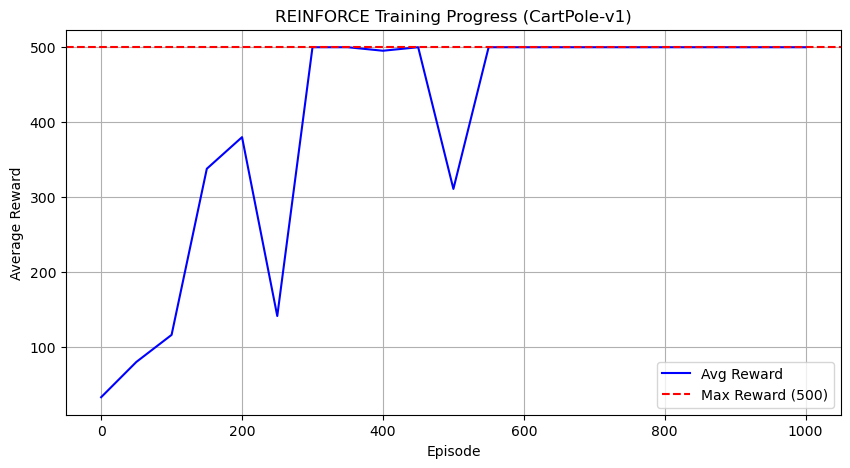

In [13]:
# 8m 39s cpu
# 14m 6s 
# gpu
device = torch.device("cpu")
use_value_baseline = False  # False for simple v

seed = 2112
torch.manual_seed(seed)
np.random.seed(seed)

env = gym.make('CartPole-v1')
env.reset(seed=seed)

policy_net = PolicyNet(env).to(device)
value_net = ValueNet(env.observation_space.shape[0]).to(device) if use_value_baseline else None

agent = REINFORCEWithBaseline(
    policy_net=policy_net,
    value_net=value_net,
    use_value_baseline=use_value_baseline,
    gamma=0.99,
    lr_policy=1e-2 #1e-3
)

# Initialize lists to store episode numbers and average rewards
episodes = []
avg_rewards = []

for episode in range(1001):
    states, actions, rewards = run_episode(env, policy_net)
    agent.update(states, actions, rewards)

    if episode % 50 == 0:
        avg_reward = evaluate_policy_baseline(env, policy_net)
        print(f"Episode {episode}, Avg Reward: {avg_reward:.1f}")

        # Store data for plotting
        episodes.append(episode)
        avg_rewards.append(avg_reward)

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards, 'b-', label='Avg Reward')
plt.title("REINFORCE Training Progress (CartPole-v1)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)

# Highlight the maximum reward (500 for CartPole)
plt.axhline(y=500, color='r', linestyle='--', label='Max Reward (500)')
plt.legend()

plt.show()


Episode 0, Avg Reward: 18.6
Episode 50, Avg Reward: 71.2
Episode 100, Avg Reward: 88.7
Episode 150, Avg Reward: 54.8
Episode 200, Avg Reward: 157.8
Episode 250, Avg Reward: 58.0
Episode 300, Avg Reward: 241.3
Episode 350, Avg Reward: 155.7
Episode 400, Avg Reward: 74.0
Episode 450, Avg Reward: 130.1
Episode 500, Avg Reward: 304.0
Episode 550, Avg Reward: 500.0
Episode 600, Avg Reward: 500.0
Episode 650, Avg Reward: 500.0
Episode 700, Avg Reward: 500.0
Episode 750, Avg Reward: 500.0
Episode 800, Avg Reward: 500.0
Episode 850, Avg Reward: 500.0
Episode 900, Avg Reward: 500.0
Episode 950, Avg Reward: 500.0
Episode 1000, Avg Reward: 500.0


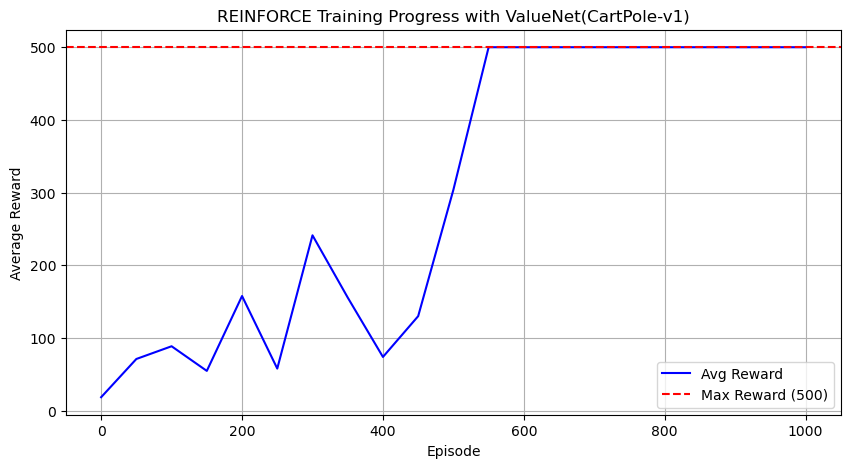

In [14]:
device = torch.device("cpu")
use_value_baseline = True  # True for using Valuenet

seed = 2112
torch.manual_seed(seed)
np.random.seed(seed)

env = gym.make('CartPole-v1')
env.reset(seed=seed)

policy_net = PolicyNet(env).to(device)
value_net = ValueNet(env.observation_space.shape[0]).to(device) if use_value_baseline else None

agent = REINFORCEWithBaseline(
    policy_net=policy_net,
    value_net=value_net,
    use_value_baseline=use_value_baseline,
    gamma=0.99,
    lr_policy=1e-2,
    lr_value=1e-3
)

# Initialize lists to store episode numbers and average rewards
episodes = []
avg_rewards = []

for episode in range(1001):
    states, actions, rewards = run_episode(env, policy_net)
    agent.update(states, actions, rewards)

    if episode % 50 == 0:
        avg_reward = evaluate_policy_baseline(env, policy_net)
        print(f"Episode {episode}, Avg Reward: {avg_reward:.1f}")

        # Store data for plotting
        episodes.append(episode)
        avg_rewards.append(avg_reward)

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards, 'b-', label='Avg Reward')
plt.title("REINFORCE Training Progress with ValueNet(CartPole-v1)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)

# Highlight the maximum reward (500 for CartPole)
plt.axhline(y=500, color='r', linestyle='--', label='Max Reward (500)')
plt.legend()

plt.show()

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

In [6]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from typing import Callable, Optional, Tuple, List, Dict
import matplotlib.pyplot as plt

np.bool8 = np.bool_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim=8, action_dim=4, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)  # New
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)  # New        
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return torch.distributions.Categorical(logits=logits)  # Return a distribution
    
class ValueNet(nn.Module):
    def __init__(self, state_dim=8, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Scalar value

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
import pygame
_ = pygame.init()
pygame.display.init()  # Might help PyGame not crash...

# Run the agent for a few episodes before training
policy_net = PolicyNet(state_dim=8, action_dim=4).to(device)

env_render = gym.make('LunarLander-v2', render_mode='human')
for _ in range(5):
    run_episode(env_render, policy_net)
env_render.close()

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Episode 0, Avg Reward: -135.2
New best model saved with average reward: -135.2
Episode 50, Avg Reward: -203.2
Episode 100, Avg Reward: -160.0
Episode 150, Avg Reward: -88.6
New best model saved with average reward: -88.6
Episode 200, Avg Reward: -193.6
Episode 250, Avg Reward: -162.2
Episode 300, Avg Reward: -98.9
Episode 350, Avg Reward: -124.1
Episode 400, Avg Reward: -124.3
Episode 450, Avg Reward: -110.6
Episode 500, Avg Reward: -75.4
New best model saved with average reward: -75.4
Episode 550, Avg Reward: -17.8
New best model saved with average reward: -17.8
Episode 600, Avg Reward: -84.5
Episode 650, Avg Reward: -18.2
Episode 700, Avg Reward: -63.0
Episode 750, Avg Reward: -42.8
Episode 800, Avg Reward: 10.3
New best model saved with average reward: 10.3
Episode 850, Avg Reward: -22.9
Episode 900, Avg Reward: -8.2
Episode 950, Avg Reward: 36.4
New best model saved with average reward: 36.4
Episode 1000, Avg Reward: 25.8
Episode 1050, Avg Reward: 72.1
New best model saved with ave

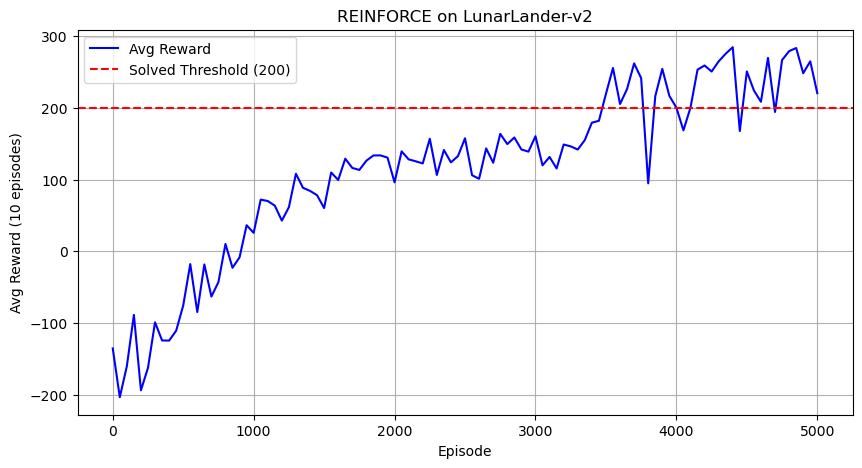

In [ ]:
# Caso Migliore
use_value_baseline = True
env = gym.make("LunarLander-v2")
policy_net = PolicyNet(state_dim=8, action_dim=4).to(device)
value_net = ValueNet(state_dim=8).to(device) if use_value_baseline else None

agent = REINFORCEWithBaseline(
    policy_net=policy_net,
    value_net=value_net,
    use_value_baseline=use_value_baseline,
    gamma=0.99,
    lr_policy= 5e-4,
    lr_value=1e-3
)

# Training
episodes = []
avg_rewards = []
best_avg_reward = float("-inf")

for episode in range(5000+1):
    states, actions, rewards = run_episode(env, policy_net)
    agent.update(states, actions, rewards)

    # Add this to your training loop after each update:
    if episode % 1000 == 0:
        for param_group in agent.optimizer_policy.param_groups:
            param_group['lr'] *= 0.8  # Gradual decay
        for param_group in agent.optimizer_value.param_groups:
            param_group['lr'] *= 0.8

    if episode % 50 == 0:
        avg_reward = evaluate_policy_baseline(env, policy_net, num_episodes=10)
        episodes.append(episode)
        avg_rewards.append(avg_reward)
        print(f"Episode {episode}, Avg Reward: {avg_reward:.1f}")

        # Save if this is the best model so far
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            torch.save({
                'policy_net_state_dict': policy_net.state_dict(),
                'value_net_state_dict': value_net.state_dict() if value_net else None,
                'optimizer_policy_state_dict': agent.optimizer_policy.state_dict(),
                'optimizer_value_state_dict': agent.optimizer_value.state_dict() if agent.optimizer_value else None,
                'episode': episode,
                'avg_reward': avg_reward
            }, f'Lunar_best_model_valueNet.pth')
            print(f"New best model saved with average reward: {avg_reward:.1f}")
        else:
            early_counter = 0

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards, 'b-', label='Avg Reward')
plt.axhline(y=200, color='r', linestyle='--', label='Solved Threshold (200)')
plt.title("REINFORCE on LunarLander-v2")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (10 episodes)")
plt.legend()
plt.grid()
plt.show()

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Episode 0, Avg Reward: -190.3
New best model saved with average reward: -190.3
Episode 50, Avg Reward: -192.1
Episode 100, Avg Reward: -208.4
Episode 150, Avg Reward: -148.6
New best model saved with average reward: -148.6
Episode 200, Avg Reward: -138.5
New best model saved with average reward: -138.5
Episode 250, Avg Reward: -182.7
Episode 300, Avg Reward: -146.2
Episode 350, Avg Reward: -117.4
New best model saved with average reward: -117.4
Episode 400, Avg Reward: -163.0
Episode 450, Avg Reward: -92.1
New best model saved with average reward: -92.1
Episode 500, Avg Reward: -125.2
Episode 550, Avg Reward: -126.7
Episode 600, Avg Reward: -190.6
Episode 650, Avg Reward: -90.6
New best model saved with average reward: -90.6
Episode 700, Avg Reward: -69.7
New best model saved with average reward: -69.7
Episode 750, Avg Reward: -74.0
Episode 800, Avg Reward: -47.6
New best model saved with average reward: -47.6
Episode 850, Avg Reward: -37.3
New best model saved with average reward: -37

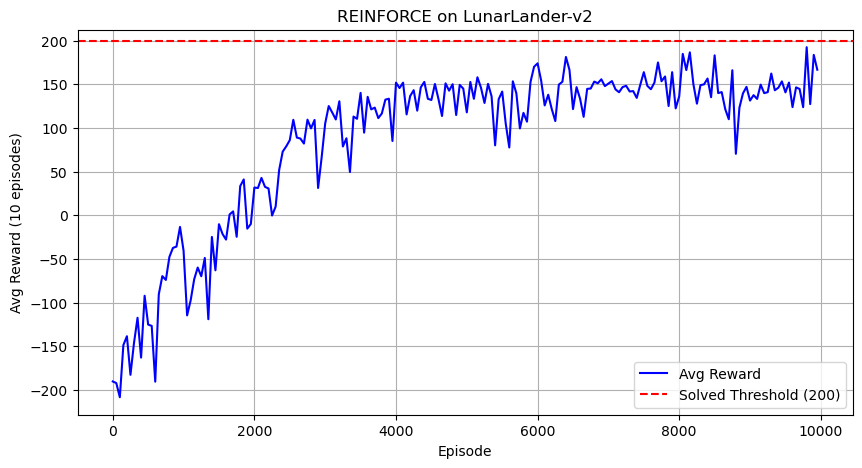

In [5]:
use_value_baseline = False # doesn't use ValueNet
env = gym.make("LunarLander-v2")
policy_net = PolicyNet(state_dim=8, action_dim=4).to(device)
value_net = ValueNet(state_dim=8).to(device) if use_value_baseline else None

agent = REINFORCEWithBaseline(
    policy_net=policy_net,
    value_net=value_net,
    use_value_baseline=use_value_baseline, 
    gamma=0.99,
    lr_policy= 3e-4,#1e-4,
    lr_value=1e-3
)

# Training
episodes = []
avg_rewards = []
best_avg_reward = float("-inf")

for episode in range(10000):
    states, actions, rewards = run_episode(env, policy_net)
    agent.update(states, actions, rewards)

    if episode % 50 == 0:
        avg_reward = evaluate_policy_baseline(env, policy_net, num_episodes=10)
        episodes.append(episode)
        avg_rewards.append(avg_reward)
        print(f"Episode {episode}, Avg Reward: {avg_reward:.1f}")

        # Save if this is the best model so far
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            torch.save({
                'policy_net_state_dict': policy_net.state_dict(),
                'value_net_state_dict': value_net.state_dict() if value_net else None,
                'optimizer_policy_state_dict': agent.optimizer_policy.state_dict(),
                'episode': episode,
                'avg_reward': avg_reward
            }, f'Lunar_best_model_NOvalueNet.pth')
            print(f"New best model saved with average reward: {avg_reward:.1f}")
        else:
            early_counter = 0

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards, 'b-', label='Avg Reward')
plt.axhline(y=200, color='r', linestyle='--', label='Solved Threshold (200)')
plt.title("REINFORCE on LunarLander-v2")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (10 episodes)")
plt.legend()
plt.grid()
plt.show()

In [6]:
import pygame
_ = pygame.init()
pygame.display.init()  # Might help PyGame not crash...

# Run the agent for a few episodes before training
#policy_net = PolicyNet(state_dim=8, action_dim=4).to(device)

env_render = gym.make('LunarLander-v2', render_mode='human')
for _ in range(10):
    run_episode(env_render, policy_net)
env_render.close()

In [ ]:
def load_model(path, policy_net, value_net=None, agent=None):
    checkpoint = torch.load(path, weights_only=False)  # Add weights_only=False
    policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    if value_net and checkpoint['value_net_state_dict']:
        value_net.load_state_dict(checkpoint['value_net_state_dict'])
    if agent:
        agent.optimizer_policy.load_state_dict(checkpoint['optimizer_policy_state_dict'])
        if agent.optimizer_value and checkpoint['optimizer_value_state_dict']:
            agent.optimizer_value.load_state_dict(checkpoint['optimizer_value_state_dict'])
    return checkpoint['episode'], checkpoint['avg_reward']

# Example usage:
# policy_net = PolicyNet(state_dim=8, action_dim=4).to(device)
# value_net = ValueNet(state_dim=8).to(device)
# agent = REINFORCEWithBaseline(...)
last_episode, best_reward = load_model('Lunar_best_model_valueNet.pth', policy_net, value_net, agent)
plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards, 'b-', label='Avg Reward')
plt.axhline(y=200, color='r', linestyle='--', label='Solved Threshold (200)')
plt.title("REINFORCE on LunarLander-v2")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (10 episodes)")
plt.legend()
plt.grid()
plt.show()

NameError: name 'policy_net' is not defined

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.uint8)
        )
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, env, gamma=0.99, lr=1e-3, tau=0.005):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.tau = tau
        
        # Networks
        self.q_net = QNetwork(self.state_dim, self.action_dim)
        self.target_net = QNetwork(self.state_dim, self.action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer()
        
        # Training history
        self.rewards_history = []
        self.avg_rewards = []
        self.epsilons = []
    
    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return self.env.action_space.sample()
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            return self.q_net(state_tensor).argmax().item()
    
    def update(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        # Current Q values
        current_q = self.q_net(states).gather(1, actions.unsqueeze(1))
        
        # Target Q values
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss
        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        for target_param, q_param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(self.tau * q_param.data + (1 - self.tau) * target_param.data)
    
    def train(self, episodes=1000, batch_size=64, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        epsilon = epsilon_start
        
        for episode in range(episodes):
            state, _ = self.env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = self.select_action(state, epsilon)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                
                self.replay_buffer.push(state, action, reward, next_state, done)
                self.update(batch_size)
                
                state = next_state
                total_reward += reward
            
            # Update tracking variables
            epsilon = max(epsilon_end, epsilon * epsilon_decay)
            self.rewards_history.append(total_reward)
            self.avg_rewards.append(np.mean(self.rewards_history[-50:]))
            self.epsilons.append(epsilon)
            
            if episode % 50 == 0:
                print(f"Episode {episode}, Avg Reward: {self.avg_rewards[-1]:.1f}, Epsilon: {epsilon:.3f}")
    
    def plot_results(self):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.rewards_history, alpha=0.3, label='Episode Reward')
        plt.plot(self.avg_rewards, linewidth=2, label='50-episode Avg')
        if hasattr(self.env.spec, 'reward_threshold'):
            plt.axhline(y=self.env.spec.reward_threshold, color='r', linestyle='--', label='Solved')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title(f'{self.env.spec.id} Training')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.epsilons)
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.title('Exploration Rate')
        
        plt.tight_layout()
        plt.show()

Training CartPole...
Episode 0, Avg Reward: 19.0, Epsilon: 0.995
Episode 50, Avg Reward: 25.6, Epsilon: 0.774
Episode 100, Avg Reward: 49.1, Epsilon: 0.603
Episode 150, Avg Reward: 56.9, Epsilon: 0.469
Episode 200, Avg Reward: 66.2, Epsilon: 0.365
Episode 250, Avg Reward: 98.5, Epsilon: 0.284
Episode 300, Avg Reward: 112.4, Epsilon: 0.221
Episode 350, Avg Reward: 356.3, Epsilon: 0.172
Episode 400, Avg Reward: 375.8, Epsilon: 0.134
Episode 450, Avg Reward: 338.9, Epsilon: 0.104
Episode 500, Avg Reward: 224.1, Epsilon: 0.081
Episode 550, Avg Reward: 233.2, Epsilon: 0.063
Episode 600, Avg Reward: 298.6, Epsilon: 0.049
Episode 650, Avg Reward: 262.3, Epsilon: 0.038
Episode 700, Avg Reward: 398.8, Epsilon: 0.030
Episode 750, Avg Reward: 356.5, Epsilon: 0.023
Episode 800, Avg Reward: 363.5, Epsilon: 0.018
Episode 850, Avg Reward: 307.5, Epsilon: 0.014
Episode 900, Avg Reward: 139.9, Epsilon: 0.011
Episode 950, Avg Reward: 404.5, Epsilon: 0.010


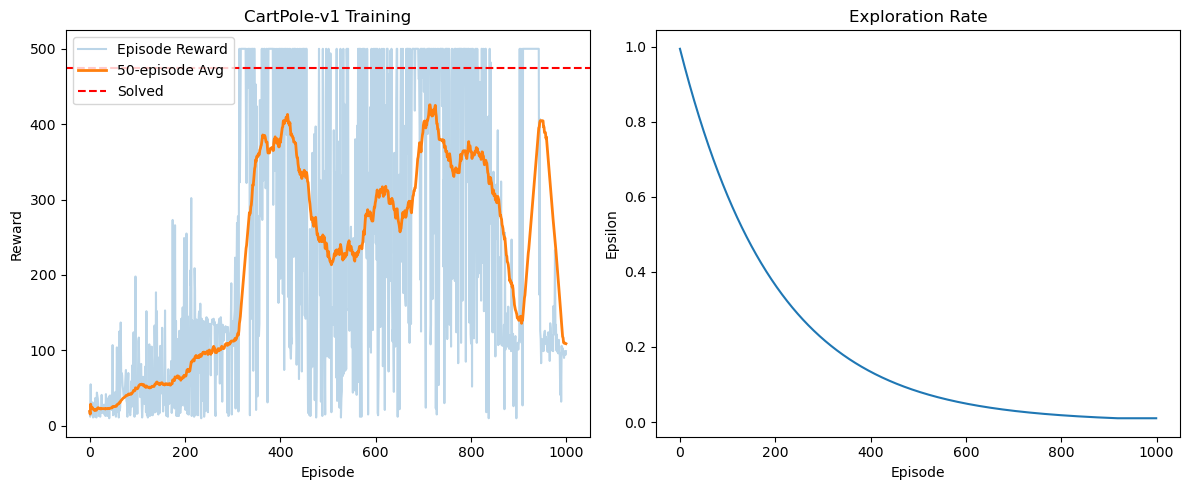

In [ ]:
# CartPole
print("Training CartPole...")
cp_env = gym.make("CartPole-v1")
cp_agent = DQNAgent(cp_env, lr=1e-3)
cp_agent.train(episodes=500)
cp_agent.plot_results()

In [ ]:
# LunarLander
print("\nTraining LunarLander...")
ll_env = gym.make("LunarLander-v2")
ll_agent = DQNAgent(ll_env, lr=5e-4)
ll_agent.train(episodes=1500)
ll_agent.plot_results()

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

 